<a href="https://colab.research.google.com/github/e11106013/RDF/blob/main/RDF_%E4%BA%A4%E9%80%9A%E9%83%A8_%E9%81%93%E8%B7%AF%E8%B7%AF%E5%90%8D%E8%A1%A8_%E7%B8%BD%E8%A1%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  原始檔案下載至 https://link.motc.gov.tw/DownloadFile
  [道路路名表-總表](https://docs.google.com/spreadsheets/d/1qjJ_D8vvfxWA_WPFxYMS9_oOYPv1XGOZ_jtwnROmy88/edit?usp=drive_link)

  "道路路名表-總表"資料內容如下表:

  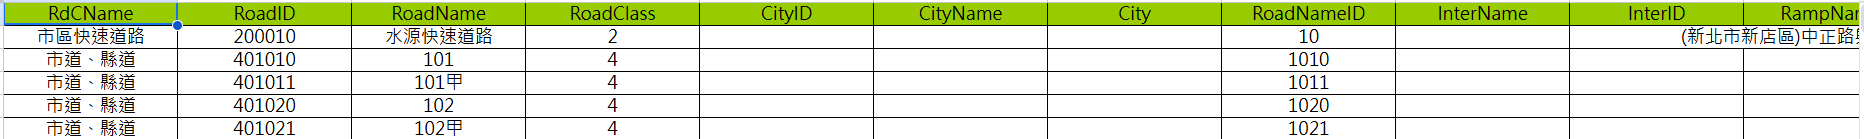

In [2]:
#@title 安裝必要的rdflib 套件
!pip install rdflib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 565.1/565.1 kB 8.3 MB/s eta 0:00:00


In [5]:
#@title 運輸場站-總表
import pandas as pd

# Excel 檔案網址
url = "https://docs.google.com/spreadsheets/d/1qjJ_D8vvfxWA_WPFxYMS9_oOYPv1XGOZ_jtwnROmy88/export?format=xlsx"

# 使用 pandas 讀取 Excel
df = pd.read_excel(url)

# 顯示欄位名稱
print(df.columns)

Index(['RdCName', 'RoadID', 'RoadName', 'RoadClass', 'CityID', 'CityName',
       'City', 'RoadNameID', 'InterName', 'InterID', 'RampName', 'RampID',
       'MileLength', 'Length', 'Version', 'UpdateDate', 'UpdateNote'],
      dtype='object')


In [7]:
#@title RDF建模
from rdflib import Graph, Literal, Namespace, URIRef
from rdflib.namespace import RDF, RDFS, XSD
import pandas as pd

# 建立 RDF graph
g = Graph()

# 定義命名空間
EX = Namespace("http://example.org/road/")
SCHEMA = Namespace("http://schema.org/")

# 在 RDF Turtle 檔案中加入對應的 @prefix 宣告
g.bind("ex", EX)            # '@prefix ex: <http://example.org/road/> .
g.bind("schema", SCHEMA)    # '@prefix schema: <http://schema.org/> .
g.bind("rdfs", RDFS)        # '@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
g.bind("xsd", XSD)          # '@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

# 載入資料（在前面的那一段程式內容得到 df，這段略過）
# url = "https://docs.google.com/spreadsheets/d/1qjJ_D8vvfxWA_WPFxYMS9_oOYPv1XGOZ_jtwnROmy88/export?format=xlsx"
# df = pd.read_excel(BytesIO(requests.get(url).content))

for _, row in df.iterrows():
    # 以 RoadID 作為主體 URI
    subject = EX[str(row["RoadID"])]

    g.add((subject, RDF.type, SCHEMA.Route))
    g.add((subject, RDFS.label, Literal(row["RoadName"])))
    g.add((subject, EX.roadChineseName, Literal(row["RdCName"])))
    g.add((subject, EX.roadClass, Literal(row["RoadClass"])))
    g.add((subject, EX.cityID, Literal(row["CityID"])))
    g.add((subject, SCHEMA.addressLocality, Literal(row["CityName"])))
    g.add((subject, SCHEMA.addressRegion, Literal(row["City"])))
    g.add((subject, EX.roadNameID, Literal(row["RoadNameID"])))
    g.add((subject, EX.intersectionName, Literal(row["InterName"])))
    g.add((subject, EX.intersectionID, Literal(row["InterID"])))
    g.add((subject, EX.rampName, Literal(row["RampName"])))
    g.add((subject, EX.rampID, Literal(row["RampID"])))

    # 數值欄位加上類型判定
    if pd.notna(row["MileLength"]):
        g.add((subject, EX.mileLength, Literal(row["MileLength"], datatype=XSD.float)))
    if pd.notna(row["Length"]):
        g.add((subject, SCHEMA.length, Literal(row["Length"], datatype=XSD.float)))

    g.add((subject, EX.version, Literal(row["Version"])))

    if pd.notna(row["UpdateDate"]):
        g.add((subject, SCHEMA.dateModified, Literal(str(row["UpdateDate"].date()), datatype=XSD.date)))

    g.add((subject, SCHEMA.description, Literal(row["UpdateNote"])))

# 儲存為 Turtle 檔案
g.serialize(destination="transport_stations.ttl", format="turtle")


<Graph identifier=N6469da1301de440184cabd11777307ff (<class 'rdflib.graph.Graph'>)>

In [10]:
#print all triples
for s, p, o in g:
    print((s, p, o))

Streaming output truncated to the last 5000 lines.
(rdflib.term.URIRef('http://example.org/road/658357N'), rdflib.term.URIRef('http://example.org/road/intersectionName'), rdflib.term.Literal('nan', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#double')))
(rdflib.term.URIRef('http://example.org/road/670186Q'), rdflib.term.URIRef('http://example.org/road/cityID'), rdflib.term.Literal('Q'))
(rdflib.term.URIRef('http://example.org/road/675229T'), rdflib.term.URIRef('http://example.org/road/intersectionID'), rdflib.term.Literal('nan', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#double')))
(rdflib.term.URIRef('http://example.org/road/605679B'), rdflib.term.URIRef('http://example.org/road/rampName'), rdflib.term.Literal('nan', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#double')))
(rdflib.term.URIRef('http://example.org/road/621016E'), rdflib.term.URIRef('http://example.org/road/intersectionName'), rdflib.term.Literal('nan', datatype=rdflib.

In [11]:
#@title 擷取一部分內容展示
g = Graph()
# create graph using turtle
turtledata = """\
@prefix ex: <http://example.org/road/> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema1: <http://schema.org/> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

ex:00001A a schema1:Route ;
    rdfs:label "國道1號汐止五股高架道路" ;
    ex:cityID "NaN"^^xsd:double ;
    ex:intersectionID "NaN"^^xsd:double,
        1e+00,
        2e+00,
        3e+00,
        4e+00,
        5e+00 ;
    ex:intersectionName "NaN"^^xsd:double,
        "下塔悠出口匝道",
        "五股轉接道",
        "堤頂交流道",
        "汐止端",
        "環北交流道" ;
    ex:mileLength "18.7"^^xsd:float ;
    ex:rampID "NaN"^^xsd:double ;
    ex:rampName "NaN"^^xsd:double ;
    ex:roadChineseName "國道" ;
    ex:roadClass 0 ;
    ex:roadNameID "0001A" ;
    ex:version "24.11.1" ;
    schema1:addressLocality "NaN"^^xsd:double ;
    schema1:addressRegion "NaN"^^xsd:double ;
    schema1:dateModified "2024-11-22"^^xsd:date ;
    schema1:description "NaN"^^xsd:double ;
    schema1:length "0.2508"^^xsd:float,
        "0.509"^^xsd:float,
        "1.9796"^^xsd:float,
        "3.5265"^^xsd:float,
        "3.7746"^^xsd:float,
        "18.6907"^^xsd:float .
"""
g.parse(data=turtledata, format="turtle")

<Graph identifier=Ne75e64b854a443a2b89a0467790230f9 (<class 'rdflib.graph.Graph'>)>

In [12]:
g.serialize(destination="filmgraph.ttl")

<Graph identifier=Ne75e64b854a443a2b89a0467790230f9 (<class 'rdflib.graph.Graph'>)>

In [13]:
#@title RDF/XML格式
print(g.serialize(format="xml"))

<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF
   xmlns:ex="http://example.org/road/"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
   xmlns:rdfs="http://www.w3.org/2000/01/rdf-schema#"
   xmlns:schema1="http://schema.org/"
>
  <rdf:Description rdf:about="http://example.org/road/00001A">
    <rdf:type rdf:resource="http://schema.org/Route"/>
    <rdfs:label>國道1號汐止五股高架道路</rdfs:label>
    <ex:cityID rdf:datatype="http://www.w3.org/2001/XMLSchema#double">nan</ex:cityID>
    <ex:intersectionID rdf:datatype="http://www.w3.org/2001/XMLSchema#double">nan</ex:intersectionID>
    <ex:intersectionID rdf:datatype="http://www.w3.org/2001/XMLSchema#double">1.0</ex:intersectionID>
    <ex:intersectionID rdf:datatype="http://www.w3.org/2001/XMLSchema#double">2.0</ex:intersectionID>
    <ex:intersectionID rdf:datatype="http://www.w3.org/2001/XMLSchema#double">3.0</ex:intersectionID>
    <ex:intersectionID rdf:datatype="http://www.w3.org/2001/XMLSchema#double">4.0</ex:intersectionID>
    

In [14]:
#@title 讀取turtle檔案中的資訊

from rdflib import Graph

g = Graph()
g.parse("transport_stations.ttl", format="turtle")

<Graph identifier=N181275cdcf8a4c4eb667f6343f2b97d7 (<class 'rdflib.graph.Graph'>)>

In [15]:
#@title 查詢道路名稱
query = """
PREFIX ex: <http://example.org/road/>
PREFIX schema: <http://schema.org/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?road ?label
WHERE {
  ?road a schema:Route ;
        rdfs:label ?label .
}
LIMIT 10
"""

results = g.query(query)

for row in results:
    print(f"道路 URI: {row['road']}，名稱: {row['label']}")

道路 URI: http://example.org/road/00001A，名稱: 國道1號汐止五股高架道路
道路 URI: http://example.org/road/00001B，名稱: 國道1號五股楊梅高架道路
道路 URI: http://example.org/road/10，名稱: 國道1號
道路 URI: http://example.org/road/100，名稱: 國道10號
道路 URI: http://example.org/road/100610，名稱: 台61線
道路 URI: http://example.org/road/100620，名稱: 台62線
道路 URI: http://example.org/road/100621，名稱: 台62甲線
道路 URI: http://example.org/road/100640，名稱: 台64線
道路 URI: http://example.org/road/100650，名稱: 台65線
道路 URI: http://example.org/road/100660，名稱: 台66線


In [21]:

#@title 查詢臺北市所有道路名稱與長度
query = """
PREFIX ex: <http://example.org/road/>
PREFIX schema: <http://schema.org/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT ?road ?label ?length
WHERE {
  ?road a schema:Route ;
        rdfs:label ?label ;
        schema:addressLocality "臺北市" ;
        schema:length ?length .
}
ORDER BY DESC(?length)
"""

results = g.query(query)

for row in results:
    print(f"道路: {row['label']}，長度: {row['length']}")

道路: 竹子湖路，長度: 21.0052
道路: 北安路，長度: 9.4957
道路: 民權東路六段，長度: 9.1939
道路: 內湖路三段，長度: 6.9316
道路: 中正路，長度: 6.8009
道路: 濱江街，長度: 6.4826
道路: 基隆路一段，長度: 6.2063
道路: 南京東路六段，長度: 5.441
道路: 新光路二段，長度: 5.3998
道路: 中山北路五段，長度: 5.2972
道路: 八德路四段，長度: 5.2649
道路: 松江路，長度: 5.2467
道路: 泉源路，長度: 5.2345
道路: 民族東路，長度: 5.0381
道路: 至善路二段，長度: 4.9699
道路: 大業路，長度: 4.9158
道路: 南深路，長度: 4.8522
道路: 和平東路三段，長度: 4.8509
道路: 碧山路，長度: 4.6301
道路: 明水路，長度: 4.5536
道路: 劍南路，長度: 4.5309
道路: 永公路，長度: 4.5155
道路: 木柵路五段，長度: 4.4682
道路: 至善路三段，長度: 4.3859
道路: 內湖路一段，長度: 4.3801
道路: 延平北路六段，長度: 4.3699
道路: 紗帽路，長度: 4.2504
道路: 忠孝東路七段，長度: 4.1709
道路: 忠孝東路四段，長度: 4.0975
道路: 復興北路，長度: 4.0573
道路: 福國路，長度: 4.0555
道路: 忠孝東路五段，長度: 4.0221
道路: 艋舺大道，長度: 4.0147
道路: 水源路，長度: 4.0123
道路: 成功路二段，長度: 4.007
道路: 指南路三段，長度: 3.9541
道路: 市民大道八段，長度: 3.9397
道路: 光復南路，長度: 3.9343
道路: 中山北路六段，長度: 3.9253
道路: 安康路，長度: 3.8903
道路: 辛亥路三段，長度: 3.8731
道路: 撫遠街，長度: 3.8573
道路: 松山路，長度: 3.7473
道路: 承德路四段，長度: 3.7031
道路: 康湖路，長度: 3.7
道路: 樂群一路，長度: 3.6515
道路: 復興三路，長度: 3.6243
道路: 指南路三段38巷，長度: 3.6219
道路: 西藏路，長度: 3.6164
道路: 萬大路